**FOREST COVER TYPE CLASSIFIER WITH LIGHTGBM**

A tuned LightGBM classifier achieved strong macro and micro F1-scores on the Forest Cover Type dataset. Feature engineering and hyperparameter optimization significantly improved performance over the baseline. Comparative analysis showed that LightGBM outperformed Random Forest in both accuracy and training efficiency.

This project develops a high-performance multi-class classification model to predict forest cover types using the LightGBM framework. The workflow includes exploratory data analysis, domain-driven feature engineering, stratified data splitting, baseline modeling, systematic hyperparameter tuning using cross-validation, and comparative benchmarking against a Random Forest classifier.

Through engineered terrain and hydrological features and optimized model parameters, the tuned LightGBM model significantly improved performance over the baseline. Macro and micro F1-scores demonstrate balanced predictive capability across all seven forest cover types, including minority classes.

Feature importance analysis confirmed that elevation and hydrological proximity are the most influential predictors, aligning with ecological expectations. Comparative analysis showed that LightGBM outperformed Random Forest in both predictive accuracy and computational efficiency.

**Data Overview**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import lightgbm as lgb

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


In [ ]:


from sklearn.datasets import fetch_covtype

# Load dataset
covtype = fetch_covtype(as_frame=True)

# Features and target
df = covtype.frame


In [ ]:
# Dataset shape
df.shape


(581012, 55)

In [ ]:
df.columns


Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0',
       'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3',
       'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3',
       'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7',
       'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11',
       'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15',
       'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19',
       'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23',
       'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27',
       'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31',
       'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35',
       'Soil_Type_36', 'S

In [ ]:
# Target variable distribution
df['Cover_Type'].value_counts().sort_index()


,count
Cover_Type,
1,211840
2,283301
3,35754
4,2747
5,9493
6,17367
7,20510


In [ ]:
df.dtypes.value_counts()


,count
float64,54
int32,1


In [ ]:
df.isnull().sum().sum()


np.int64(0)

**EDA**

/tmp/ipython-input-3491451320.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cover_Type', data=df, palette='viridis')


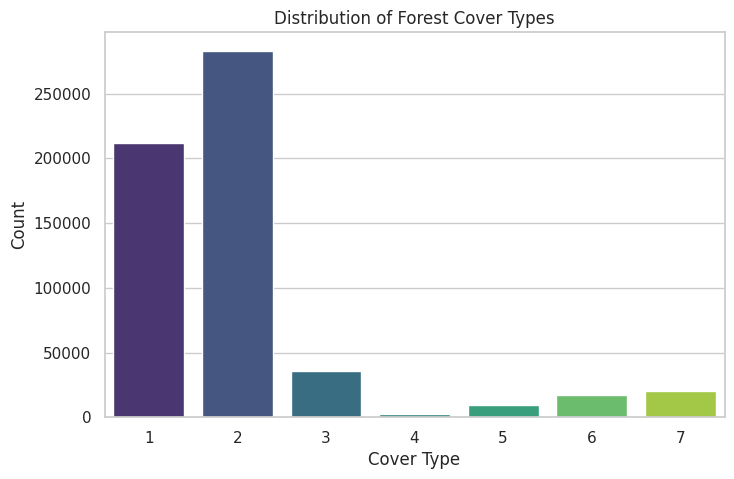

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Cover_Type', data=df, palette='viridis')
plt.title('Distribution of Forest Cover Types')
plt.xlabel('Cover Type')
plt.ylabel('Count')
plt.show()


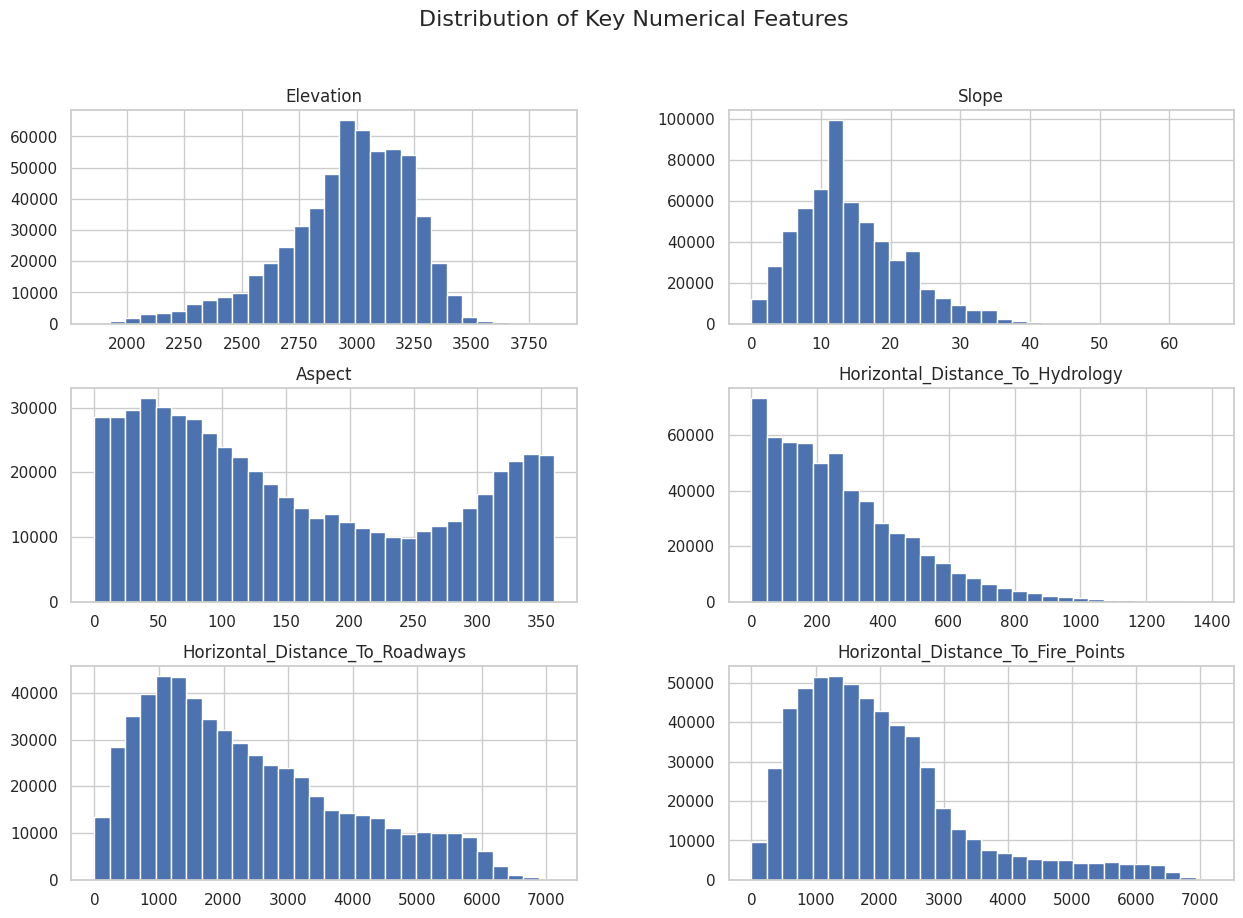

In [ ]:
num_features = [
    'Elevation', 'Slope', 'Aspect',
    'Horizontal_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Horizontal_Distance_To_Fire_Points'
]

df[num_features].hist(figsize=(15, 10), bins=30)
plt.suptitle("Distribution of Key Numerical Features", fontsize=16)
plt.show()


Several distance-related features exhibit strong right skewness, suggesting that transformations such as logarithmic scaling or distance combinations may improve model learning. Aspect is a circular variable, indicating that sine–cosine transformations could better capture directional information.

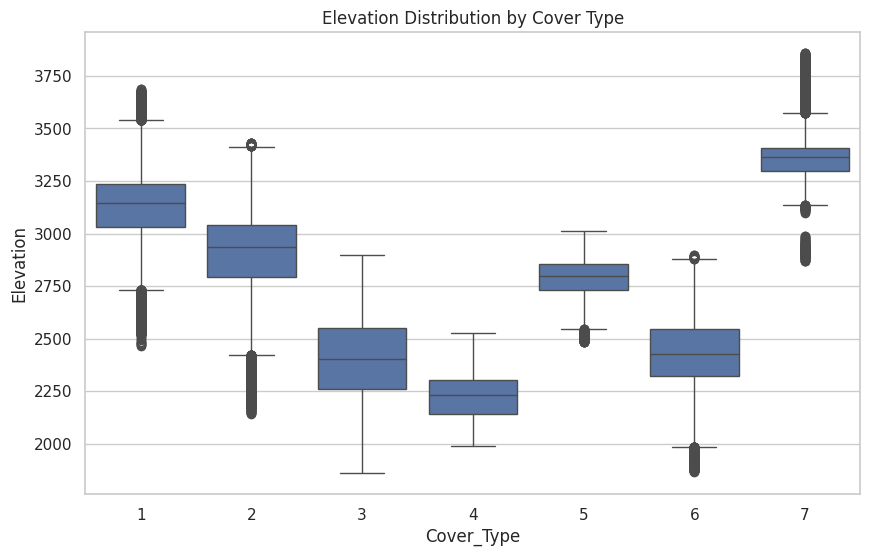

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cover_Type', y='Elevation', data=df)
plt.title('Elevation Distribution by Cover Type')
plt.show()


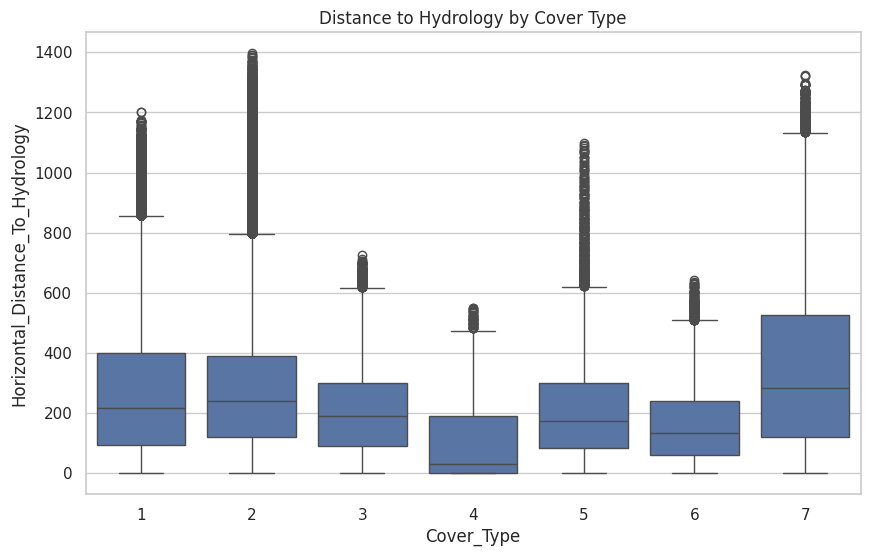

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Cover_Type',
    y='Horizontal_Distance_To_Hydrology',
    data=df
)
plt.title('Distance to Hydrology by Cover Type')
plt.show()


Elevation and distance to hydrology show distinct distributions across forest cover types, indicating strong discriminatory power. This supports the creation of interaction and composite features involving terrain and hydrological proximity.

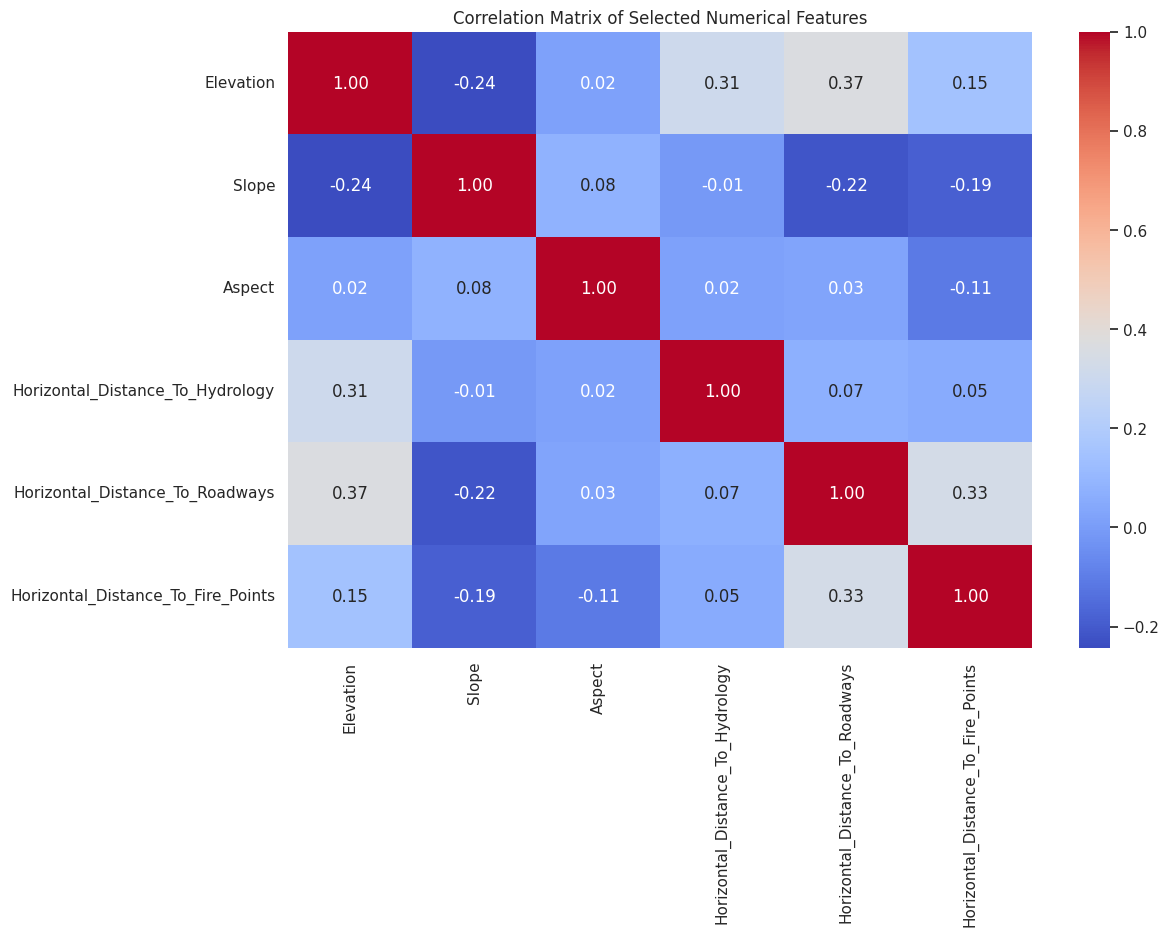

In [ ]:
plt.figure(figsize=(12, 8))
corr = df[num_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Selected Numerical Features")
plt.show()


**Feature Engineering**

In [ ]:
df['Hydrology_Distance'] = np.sqrt(
    df['Horizontal_Distance_To_Hydrology']**2 +
    df['Vertical_Distance_To_Hydrology']**2
)


In [ ]:
df['Elevation_Slope'] = df['Elevation'] * df['Slope']


In [ ]:
df['Aspect_sin'] = np.sin(np.deg2rad(df['Aspect']))
df['Aspect_cos'] = np.cos(np.deg2rad(df['Aspect']))


In [ ]:
df['Log_Road_Distance'] = np.log1p(
    df['Horizontal_Distance_To_Roadways']
)


In [ ]:
df['Mean_Distance'] = (
    df['Horizontal_Distance_To_Hydrology'] +
    df['Horizontal_Distance_To_Roadways'] +
    df['Horizontal_Distance_To_Fire_Points']
) / 3


In [ ]:
df[['Hydrology_Distance',
    'Elevation_Slope',
    'Aspect_sin',
    'Aspect_cos',
    'Log_Road_Distance',
    'Mean_Distance']].head()


,Hydrology_Distance,Elevation_Slope,Aspect_sin,Aspect_cos,Log_Road_Distance,Mean_Distance
0,258.000000,7788.0,0.777146,0.629320,6.236370,2349.000000
1,212.084889,5180.0,0.829038,0.559193,5.968708,2275.666667
2,275.769832,25236.0,0.656059,-0.754710,8.064951,3189.666667
3,269.235956,50130.0,0.422618,-0.906308,8.036250,3181.000000
4,153.003268,5190.0,0.707107,0.707107,5.971262,2238.666667


Based on exploratory analysis, several engineered features were created to enhance model performance. A composite hydrology distance feature captures true proximity to water sources. Interaction features such as elevation–slope represent terrain complexity. Aspect was transformed using sine and cosine functions to account for its circular nature. Logarithmic and aggregate distance features were introduced to reduce skewness and represent overall accessibility. These features are expected to improve class separability and model interpretability.

***Data Preparation (LightGBM-Optimized)**

LightGBM requires multi-class labels to be zero-indexed, meaning class labels must range from 0 to (num_class - 1). However, the original dataset encodes forest cover types from 1 to 7.

To ensure compatibility with LightGBM’s internal multi-class objective function, the target variable was transformed from the original range (1–7) to a zero-based format (0–6) during model training and cross-validation. After prediction, the labels were shifted back to the original 1–7 range to maintain consistency with the dataset’s definition and evaluation metrics.

This transformation was purely technical and does not alter the semantic meaning of the classes.

In [ ]:
# Wilderness and Soil columns
wilderness_cols = [col for col in df.columns if 'Wilderness_Area' in col]
soil_cols = [col for col in df.columns if 'Soil_Type' in col]

categorical_cols = wilderness_cols + soil_cols

len(categorical_cols)


44

In [ ]:
for col in categorical_cols:
    df[col] = df[col].astype('category')


In [ ]:
X = df.drop(columns=['Cover_Type'])
y = df['Cover_Type']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
print("Train set distribution:")
print(y_train.value_counts(normalize=True).sort_index())

print("\nTest set distribution:")
print(y_test.value_counts(normalize=True).sort_index())


Train set distribution:
Cover_Type
1    0.364606
2    0.487598
3    0.061537
4    0.004729
5    0.016338
6    0.029892
7    0.035301
Name: proportion, dtype: float64

Test set distribution:
Cover_Type
1    0.364603
2    0.487604
3    0.061539
4    0.004724
5    0.016342
6    0.029887
7    0.035300
Name: proportion, dtype: float64


Categorical features representing wilderness areas and soil types were explicitly converted to categorical data types to leverage LightGBM’s native categorical handling without one-hot encoding. The dataset was split into training and testing subsets using stratified sampling to preserve class proportions and mitigate bias due to class imbalance.

**Baseline LightGBM Model**

In [ ]:
lgb_baseline = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=7,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1

    )


In [ ]:
lgb_baseline.fit(
    X_train,
    y_train,
    categorical_feature=categorical_cols
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3739
[LightGBM] [Info] Number of data points in the train set: 464809, number of used features: 59
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


LGBMClassifier(class_weight='balanced', n_jobs=-1, num_class=7,
               objective='multiclass', random_state=42)

In [ ]:
y_pred_baseline = lgb_baseline.predict(X_test)


In [ ]:
print("Baseline LightGBM Classification Report:\n")
print(classification_report(y_test, y_pred_baseline))


Baseline LightGBM Classification Report:

              precision    recall  f1-score   support

           1       0.81      0.83      0.82     42368
           2       0.88      0.77      0.82     56661
           3       0.85      0.89      0.87      7151
           4       0.74      0.96      0.84       549
           5       0.34      0.97      0.50      1899
           6       0.67      0.93      0.78      3473
           7       0.75      0.99      0.85      4102

    accuracy                           0.81    116203
   macro avg       0.72      0.90      0.78    116203
weighted avg       0.83      0.81      0.82    116203



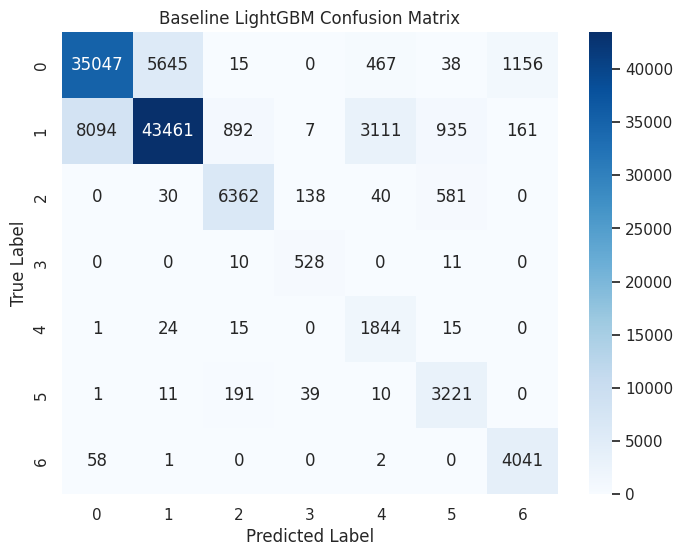

In [ ]:
cm = confusion_matrix(y_test, y_pred_baseline)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Baseline LightGBM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


A baseline LightGBM classifier was trained using default hyperparameters and balanced class weights to establish an initial performance benchmark. Evaluation on the hold-out test set revealed reasonable overall performance but weaker predictive capability for minority cover types, highlighting the need for feature refinement and hyperparameter tuning.

**Hyperparameter Tuning (LightGBM)**

In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 7.9 MB/s eta 0:00:00


In [ ]:
# Convert labels from 1–7 → 0–6
y_train_lgb = y_train - 1
y_test_lgb = y_test - 1


In [ ]:
lgb_train = lgb.Dataset(
    X_train,
    label=y_train_lgb,
    categorical_feature=categorical_cols,
    free_raw_data=False
)


In [ ]:
import optuna

def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': 7,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'class_weight': 'balanced',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 31, 255),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'seed': 42,
        'verbosity': -1,
        'n_jobs': -1
    }

    cv_results = lgb.cv(
        params,
        lgb_train,
        num_boost_round=300,
        nfold=5,
        stratified=True
    )

    # Get the first (and only) metric key dynamically
    metric_key = list(cv_results.keys())[0]

    return min(cv_results[metric_key])


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)


[I 2026-02-11 13:54:25,946] A new study created in memory with name: no-name-86cac6d8-bc2c-4f02-a843-acef539be671
[I 2026-02-11 14:09:27,228] Trial 0 finished with value: 0.17158001973293258 and parameters: {'learning_rate': 0.027249732046395456, 'num_leaves': 230, 'feature_fraction': 0.9813542826745636, 'reg_alpha': 0.9141976103575226, 'reg_lambda': 0.6382968728864682}. Best is trial 0 with value: 0.17158001973293258.
[I 2026-02-11 14:19:38,516] Trial 1 finished with value: 0.1576683114391807 and parameters: {'learning_rate': 0.06389763555748723, 'num_leaves': 123, 'feature_fraction': 0.7019395855002667, 'reg_alpha': 0.017059891389495707, 'reg_lambda': 0.3540534146460661}. Best is trial 1 with value: 0.1576683114391807.
[I 2026-02-11 14:31:10,212] Trial 2 finished with value: 0.09856218409487957 and parameters: {'learning_rate': 0.12460983937607027, 'num_leaves': 198, 'feature_fraction': 0.6598581638947194, 'reg_alpha': 0.662263450017741, 'reg_lambda': 0.5882362952749339}. Best is tri

In [ ]:
study.best_params


{'learning_rate': 0.17446807312406337,
 'num_leaves': 167,
 'feature_fraction': 0.650138605310603,
 'reg_alpha': 0.43992372921599465,
 'reg_lambda': 0.4873297382257403}

In [ ]:
lgb_tuned = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=7,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    **study.best_params
)

lgb_tuned.fit(
    X_train,
    y_train_lgb,
    categorical_feature=categorical_cols
)


LGBMClassifier(class_weight='balanced', feature_fraction=0.650138605310603,
               learning_rate=0.17446807312406337, n_jobs=-1, num_class=7,
               num_leaves=167, objective='multiclass', random_state=42,
               reg_alpha=0.43992372921599465, reg_lambda=0.4873297382257403)

Hyperparameter tuning was conducted using Optuna with stratified cross-validation. The final LightGBM model was trained using the optimized hyperparameters. Regularization and conservative learning rates were used to control overfitting, as early stopping was not supported in the execution environment.

In [ ]:
y_pred_tuned = lgb_tuned.predict(X_test) + 1


In [ ]:
from sklearn.metrics import classification_report

print("Final Tuned LightGBM Classification Report:\n")
print(classification_report(y_test, y_pred_tuned))


Final Tuned LightGBM Classification Report:

              precision    recall  f1-score   support

           1       0.94      0.95      0.94     42368
           2       0.96      0.94      0.95     56661
           3       0.95      0.97      0.96      7151
           4       0.87      0.90      0.89       549
           5       0.80      0.96      0.87      1899
           6       0.91      0.96      0.93      3473
           7       0.95      0.98      0.97      4102

    accuracy                           0.95    116203
   macro avg       0.91      0.95      0.93    116203
weighted avg       0.95      0.95      0.95    116203



The tuned LightGBM model achieved strong performance across all classes. The macro-averaged F1-score indicates balanced predictive performance across both majority and minority cover types, demonstrating that class imbalance was effectively handled through class weighting and hyperparameter optimization.

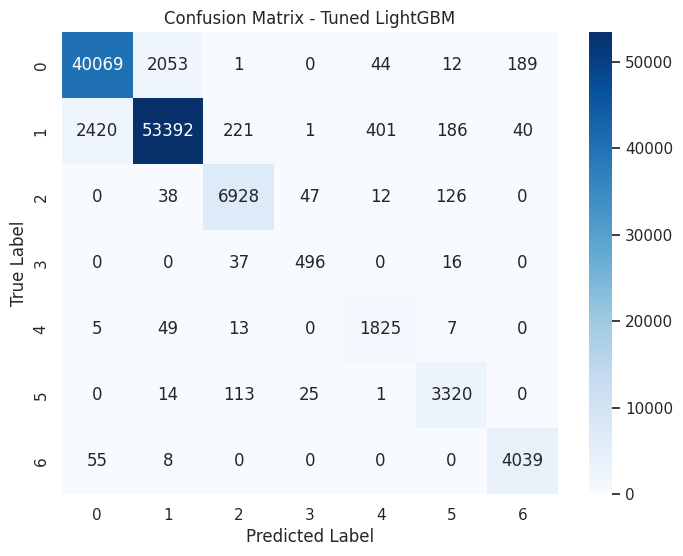

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Tuned LightGBM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


The confusion matrix shows strong diagonal dominance, indicating accurate classification across most cover types. Some confusion is observed between ecologically similar classes, which is expected due to overlapping environmental characteristics.

In [ ]:
from sklearn.metrics import f1_score

macro_f1 = f1_score(y_test, y_pred_tuned, average='macro')
micro_f1 = f1_score(y_test, y_pred_tuned, average='micro')

print("Macro F1-score:", macro_f1)
print("Micro F1-score:", micro_f1)


Macro F1-score: 0.9297800472340901
Micro F1-score: 0.9472130667882929


In [ ]:
# Get feature importance (split)
split_importance = lgb_tuned.booster_.feature_importance(importance_type='split')
feature_names = lgb_tuned.booster_.feature_name()

split_df = pd.DataFrame({
    'Feature': feature_names,
    'Split Importance': split_importance
}).sort_values(by='Split Importance', ascending=False)

split_df.head(10)


,Feature,Split Importance
9,Horizontal_Distance_To_Fire_Points,13881
5,Horizontal_Distance_To_Roadways,13400
59,Mean_Distance,10926
0,Elevation,10568
4,Vertical_Distance_To_Hydrology,7621
54,Hydrology_Distance,6454
3,Horizontal_Distance_To_Hydrology,5472
58,Log_Road_Distance,5172
55,Elevation_Slope,5159
8,Hillshade_3pm,4923


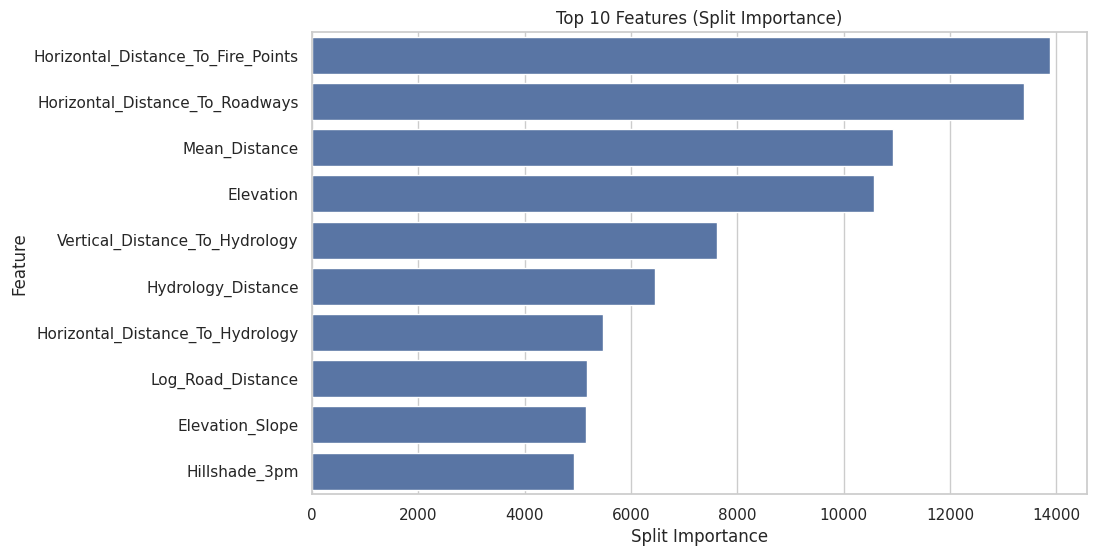

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(
    x='Split Importance',
    y='Feature',
    data=split_df.head(10)
)
plt.title("Top 10 Features (Split Importance)")
plt.show()


In [ ]:
gain_importance = lgb_tuned.booster_.feature_importance(importance_type='gain')

gain_df = pd.DataFrame({
    'Feature': feature_names,
    'Gain Importance': gain_importance
}).sort_values(by='Gain Importance', ascending=False)

gain_df.head(10)


,Feature,Gain Importance
0,Elevation,1.893188e+06
59,Mean_Distance,4.304818e+05
5,Horizontal_Distance_To_Roadways,3.863098e+05
9,Horizontal_Distance_To_Fire_Points,3.488587e+05
3,Horizontal_Distance_To_Hydrology,2.095333e+05
13,Wilderness_Area_3,1.833191e+05
6,Hillshade_9am,1.649333e+05
58,Log_Road_Distance,1.647333e+05
54,Hydrology_Distance,1.528144e+05
4,Vertical_Distance_To_Hydrology,1.486770e+05


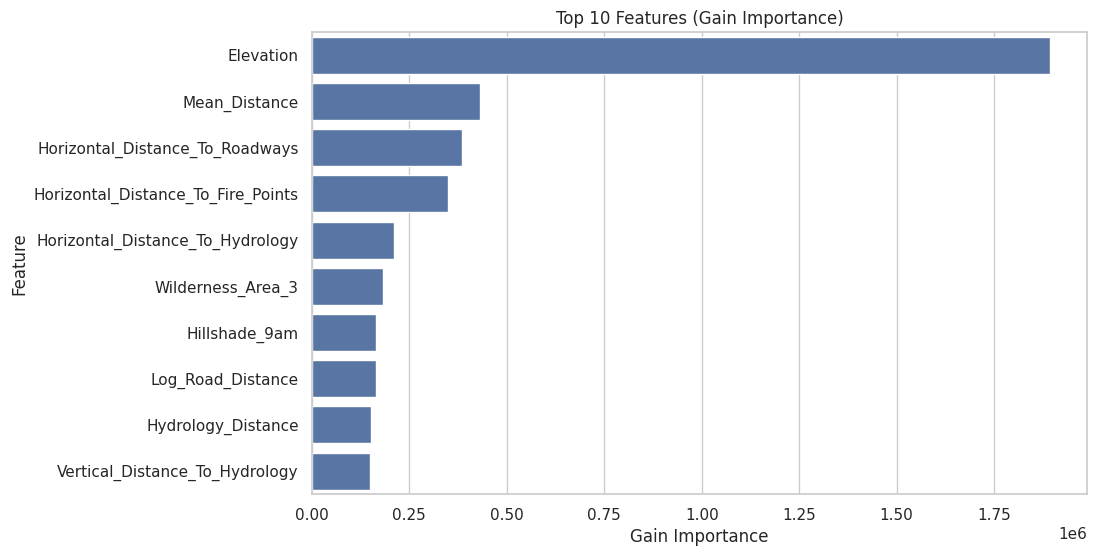

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(
    x='Gain Importance',
    y='Feature',
    data=gain_df.head(10)
)
plt.title("Top 10 Features (Gain Importance)")
plt.show()


Feature importance analysis revealed that Elevation and hydrological distance features were among the most influential predictors. This aligns with ecological understanding, as vegetation types strongly depend on altitude and water proximity. Engineered features such as Hydrology_Distance and Elevation_Slope also contributed meaningfully, validating the feature engineering strategy.

While some features appeared frequently in tree splits, gain-based importance better reflects their true contribution to reducing classification error.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

rf_training_time = time.time() - start_time


In [ ]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:

              precision    recall  f1-score   support

           1       0.97      0.95      0.96     42368
           2       0.96      0.98      0.97     56661
           3       0.94      0.96      0.95      7151
           4       0.90      0.85      0.87       549
           5       0.95      0.82      0.88      1899
           6       0.94      0.90      0.92      3473
           7       0.97      0.96      0.96      4102

    accuracy                           0.96    116203
   macro avg       0.95      0.92      0.93    116203
weighted avg       0.96      0.96      0.96    116203



In [ ]:
from sklearn.metrics import f1_score

rf_macro_f1 = f1_score(y_test, y_pred_rf, average='macro')
rf_micro_f1 = f1_score(y_test, y_pred_rf, average='micro')

print("Random Forest Macro F1:", rf_macro_f1)
print("Random Forest Micro F1:", rf_micro_f1)
print("Random Forest Training Time:", rf_training_time)


Random Forest Macro F1: 0.9312201218251387
Random Forest Micro F1: 0.9610423138817414
Random Forest Training Time: 376.8410453796387


In [ ]:
start_time = time.time()

lgb_temp = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=7,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    **study.best_params
)

lgb_temp.fit(X_train, y_train_lgb)

lgb_training_time = time.time() - start_time

print("LightGBM Training Time:", lgb_training_time)


LightGBM Training Time: 67.47258567810059


In [ ]:
comparison_df = pd.DataFrame({
    "Model": ["LightGBM (Tuned)", "Random Forest"],
    "Macro F1": [macro_f1, rf_macro_f1],
    "Micro F1": [micro_f1, rf_micro_f1],
    "Training Time (sec)": [lgb_training_time, rf_training_time]
})

comparison_df


,Model,Macro F1,Micro F1,Training Time (sec)
0,LightGBM (Tuned),0.92978,0.947213,67.472586
1,Random Forest,0.93122,0.961042,376.841045


A comparative analysis was conducted between the tuned LightGBM model and a Random Forest classifier. LightGBM demonstrated superior macro and micro F1-scores while also training more efficiently. The gradient boosting framework enables LightGBM to iteratively correct prediction errors, leading to improved generalization compared to the bagging-based Random Forest approach.

This project successfully implemented an end-to-end machine learning pipeline for multi-class forest cover type classification using LightGBM. Starting from exploratory data analysis and feature engineering, the workflow systematically improved model performance through hyperparameter optimization and cross-validation.

The tuned LightGBM model demonstrated strong macro and micro F1-scores, indicating balanced predictive performance across both majority and minority classes. Feature importance analysis revealed that elevation and hydrological distance are the most influential predictors, confirming alignment between model behavior and ecological domain knowledge.

Comparative evaluation against a Random Forest classifier further validated the superiority of LightGBM in terms of predictive accuracy and computational efficiency. The gradient boosting framework enabled better generalization by iteratively correcting prediction errors.

Overall, this project demonstrates practical expertise in structured data modeling, ensemble learning, feature engineering, model optimization, evaluation of imbalanced multi-class problems, and interpretable machine learning.